# mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive

MyDrive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/content_based_recommendation


In [ ]:
! ls

amazon_review.ipynb	mind
avito_dataset		mind_news_recommendation_data_process.ipynb
avito.ipynb		mind_news_recommendation_distilbert.ipynb
livedoor_doc2vec.ipynb


# import modules

In [ ]:
import os
import re
import time
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

from wordcloud import WordCloud

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

# download data

https://msnews.github.io/

# load data

In [ ]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"

In [ ]:
# filename_train_all = data_path_train + "news_click_df_all.csv"
filename_train_all = data_path_train + "news_click_df_select.csv"
filename_train = data_path_train + "news_click_df.csv"
data_df_train = pd.read_csv(filename_train_all)
print (data_df_train["click_prob_flag"].value_counts())
print (data_df_train["category_flag"].value_counts())
data_df_train.head(2)

0    63276
1       37
Name: click_prob_flag, dtype: int64
2    32020
1    30478
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,non_click,click,click_prob,click_prob_flag,category_flag
0,1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on last year's models.,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [42], ""SurfaceForms"": [""iPads""]}, {""Label"": ""Walmart"", ""Type"": ""O"", ""WikidataId"": ""Q483551"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Walmart""]}]","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [12], ""SurfaceForms"": [""iPad""]}, {""Label"": ""Apple Inc."", ""Type"": ""O"", ""WikidataId"": ""Q312"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Apple""]}]",NaN,NaN,0.0,0,1
1,4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War,"Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.",https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId"": ""Q212"", ""Confidence"": 0.946, ""OccurrenceOffsets"": [87], ""SurfaceForms"": [""Ukraine""]}]",NaN,NaN,0.0,0,1


In [ ]:
# filename_test_all = data_path_test + "news_click_df_all.csv"
filename_test_all = data_path_test + "news_click_df_select.csv"
filename_test = data_path_test + "news_click_df.csv"
data_df_test = pd.read_csv(filename_test_all)
print (data_df_test["click_prob_flag"].value_counts())
print (data_df_test["category_flag"].value_counts())

0    51662
1       70
Name: click_prob_flag, dtype: int64
1    26134
2    24640
0      958
Name: category_flag, dtype: int64


In [ ]:
data_df_train.count()

Unnamed: 0           63313
id                   63313
category             63313
subcategory          63313
title                63313
abstract             59794
url                  63313
title_entities       63312
abstract_entities    63310
non_click            15261
click                15261
click_prob           63313
click_prob_flag      63313
category_flag        63313
dtype: int64

## select data

In [ ]:
data_df_train["text"] = data_df_train["title"] #+ ". " + data_df_train["abstract"]
data_df_test["text"] = data_df_test["title"] #+ ". " + data_df_test["abstract"]
data_df_train["label"] = data_df_train["category_flag"] # category_flag # click_prob_flag
data_df_test["label"] = data_df_test["category_flag"]

select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())

def select_data(data_df_train, select_col, filename_train):
    select_data_df_train = data_df_train[select_col].tail(int(len(data_df_train)/50))
    select_data_df_train.to_csv(filename_train, index=False)
    print (select_data_df_train["label"].value_counts())
    return select_data_df_train

select_data_df_train = select_data(data_df_train, select_col, filename_train)
select_data_df_test = select_data(data_df_test, select_col, filename_test)
select_data_df_train.head(2)

2    753
1    500
0     13
Name: label, dtype: int64
1    586
2    396
0     52
Name: label, dtype: int64


,text,label
62047,Instagram cribs TikTok with new music-heavy Stories features,1
62048,"Red Sox Offseason Preview: Mookie Betts Situation Looms, And What About Pitching?",2


In [ ]:
# data_df_train[data_df_train["text"].isnull()].head()
select_data_df_train.head()

,text,label
62047,Instagram cribs TikTok with new music-heavy Stories features,1
62048,"Red Sox Offseason Preview: Mookie Betts Situation Looms, And What About Pitching?",2
62049,Watch: Jason Garrett has great reaction to Amari Cooper TD,2
62050,"Falcoholinks: All the Falcons news you need for Tuesday, Nov. 12",2
62051,Chargers vs. Raiders highlights | Week 10,2


In [ ]:
data_df_train.iloc[62047:62049].head(2)
# data_df_train.head(2)

,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,non_click,click,click_prob,click_prob_flag,category_flag,text,label
62047,99629,N36857,news,newsscienceandtechnology,Instagram cribs TikTok with new music-heavy Stories features,"Facebook may be for boomers, but the company has had more success keeping younger users on Instagram. The evolving requirements of social media demand constant innovation though, and Instagram is working to stay relevant by incorporating features popularized by one of its fastest-growing rivals: TikTok. Staring in Brazil, Instagram has begun testing a new format called Reels. TechCrunch reports that Reels lets you create ""15-second video video...",https://assets.msn.com/labs/mind/BBWDEYl.html,"[{""Label"": ""Instagram"", ""Type"": ""W"", ""WikidataId"": ""Q209330"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0, 44], ""SurfaceForms"": [""Instagram"", ""Stories""]}, {""Label"": ""TikTok"", ""Type"": ""N"", ""WikidataId"": ""Q48938223"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [16], ""SurfaceForms"": [""TikTok""]}]","[{""Label"": ""Instagram"", ""Type"": ""W"", ""WikidataId"": ""Q209330"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [91, 183, 324], ""SurfaceForms"": [""Instagram"", ""Instagram"", ""Instagram""]}, {""Label"": ""TikTok"", ""Type"": ""N"", ""WikidataId"": ""Q48938223"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [297], ""SurfaceForms"": [""TikTok""]}, {""Label"": ""TechCrunch"", ""Type"": ""M"", ""WikidataId"": ""Q1022366"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [379], ""SurfaceForms"": [""TechCrunch""]}, {""Label"": ""Facebook"", ""Type"": ""O"", ""WikidataId"": ""Q355"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Facebook""]}]",231.0,1.0,0.00431,0,1,Instagram cribs TikTok with new music-heavy Stories features,1
62048,99630,N85712,sports,baseball_mlb,"Red Sox Offseason Preview: Mookie Betts Situation Looms, And What About Pitching?",https://www.dailymotion.com/embed/video/x nq ej autoPlay= A lot can happen in a year -- just ask the Boston Red Sox. At this time last year the Red Sox were still basking in,https://assets.msn.com/labs/mind/BBWyPqB.html,"[{""Label"": ""Boston Red Sox"", ""Type"": ""O"", ""WikidataId"": ""Q213959"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Red Sox""]}]","[{""Label"": ""Boston Red Sox"", ""Type"": ""O"", ""WikidataId"": ""Q213959"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [101, 144], ""SurfaceForms"": [""Boston Red Sox"", ""Red Sox""]}]",19.0,1.0,0.05000,0,2,"Red Sox Offseason Preview: Mookie Betts Situation Looms, And What About Pitching?",2


# Doc2vec

In [ ]:
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import utils
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# get data
train_text = select_data_df_train["text"].values.tolist()
train_label = select_data_df_train["label"].values

test_text = select_data_df_test["text"].values.tolist()
test_label = select_data_df_test["label"].values.tolist()

train_text[0]

'Instagram cribs TikTok with new music-heavy Stories features'

In [ ]:
# tag text
train_text_tag = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_text)]
train_text_tag[0:5]

[TaggedDocument(words='Instagram cribs TikTok with new music-heavy Stories features', tags=[0]),
 TaggedDocument(words='Red Sox Offseason Preview: Mookie Betts Situation Looms, And What About Pitching?', tags=[1]),
 TaggedDocument(words='Watch: Jason Garrett has great reaction to Amari Cooper TD', tags=[2]),
 TaggedDocument(words='Falcoholinks: All the Falcons news you need for Tuesday, Nov. 12', tags=[3]),
 TaggedDocument(words='Chargers vs. Raiders highlights | Week 10', tags=[4])]

In [ ]:
%time
# #### model
# dm=0: distributed bag of words (PV-DBOW)
# dm=1: distributed memory (PV-DM)
# min_count: ignores all words with total frequency lower than this
# negative: specifies how many “noise words” should be drawn.
# hs: and negative is non-zero, negative sampling will be used.
# sample: the threshold for configuring which higher-frequency words are randomly down sampled.
# workers: use these many worker threads to train the model (=faster training with multicore machines)

model = Doc2Vec(train_text_tag, dm=0, vector_size=20, window=5, min_count=1, workers=4, epochs=100)
filename = data_path_train + "doc2vec_model.model"
model.save(filename)
model

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 17.2 µs


In [ ]:
# %time
# for epoch in range(50):
#     model.train(utils.shuffle([x for x in tqdm(train_text_tag)]), 
#                      total_examples=len(train_text_tag), epochs=1)
#     model.alpha -= 0.002
#     model.min_alpha = model.alpha

In [ ]:
model.infer_vector(train_text[0])

array([ 0.03985522,  0.25897408, -0.69859517, -0.8818961 , -0.42053276,
        0.4673261 ,  0.2870026 , -0.6342807 , -0.18189275, -0.05309998,
        0.5957294 ,  0.6135176 ,  0.16573878,  0.46472797,  0.34841886,
        0.16335872,  0.24228537, -0.07848398,  0.02812373, -0.03916924],
      dtype=float32)

In [ ]:
model.docvecs[0]

array([-0.01023237,  0.21719286, -0.6762367 , -0.6117356 , -0.37142065,
        0.43524837,  0.24129966, -0.60461277, -0.13315591, -0.06274315,
        0.48404956,  0.5913501 ,  0.14223935,  0.45524055,  0.2967692 ,
       -0.019019  ,  0.22603181, -0.06192289,  0.07060652, -0.00080427],
      dtype=float32)

In [ ]:
model.infer_vector(train_text[0])

array([ 0.0419291 ,  0.27518004, -0.719949  , -0.95988965, -0.38360056,
        0.51388186,  0.26608756, -0.65142834, -0.17486997, -0.04761426,
        0.5389041 ,  0.6263256 ,  0.16457823,  0.55085194,  0.36054948,
        0.2089387 ,  0.2056826 , -0.07697891,  0.13330442,  0.1139131 ],
      dtype=float32)

In [ ]:
model.docvecs.most_similar(0)

[(18, 0.8119866847991943),
 (1084, 0.7690472602844238),
 (326, 0.761599063873291),
 (432, 0.7062714099884033),
 (126, 0.6930369138717651),
 (6, 0.6800166368484497),
 (1033, 0.6785601377487183),
 (655, 0.6747341156005859),
 (122, 0.6708782911300659),
 (92, 0.667194664478302)]

In [ ]:
# get vectors of text
vector_result_list = []
for i in range(len(train_text)):
    vector_result = model.docvecs[i]
    vector_result_list.append(vector_result)
# vector_result_list

In [ ]:
# fit vectors using TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vector_result_list)
tsne_results

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1266 samples in 0.003s...
[t-SNE] Computed neighbors for 1266 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1266
[t-SNE] Computed conditional probabilities for sample 1266 / 1266
[t-SNE] Mean sigma: 0.592071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.096268
[t-SNE] KL divergence after 300 iterations: 2.374941


array([[-0.04646614,  6.4405456 ],
       [-0.06003083, -5.587456  ],
       [ 6.359499  ,  4.565423  ],
       ...,
       [ 1.1442587 ,  2.3518455 ],
       [-2.65234   ,  0.39423677],
       [-3.6941214 ,  4.1475587 ]], dtype=float32)

In [ ]:
palette = np.array(sns.color_palette("hls", num_classes))
print (num_classes)
palette

3


array([[0.86  , 0.3712, 0.34  ],
       [0.34  , 0.86  , 0.3712],
       [0.3712, 0.34  , 0.86  ]])

In [ ]:
palette[list(train_label-1)[0:len(train_label)]]
print(np.unique(train_label))
# list(train_label)

[0 1 2]


In [ ]:
tsne_results[1:2,0]

array([-0.06003083], dtype=float32)

(-12.99651255607605,
 12.885280752182007,
 -13.294621133804322,
 13.283116960525513)

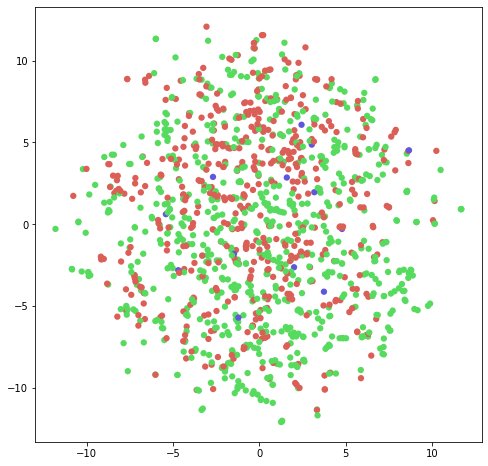

In [ ]:
# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(tsne_results[:,0], tsne_results[:,1], lw=0, s=40, c=palette[list(train_label-1)[0:len(train_label)]])
ax.axis('tight')

## classify test

In [ ]:
import torch
import torchtext
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

In [ ]:
X = []
for i in range(len(train_text)):
    X.append(model.infer_vector(train_text[i]))
train_x = np.asarray(X)
print(train_x.shape)

X = []
for i in range(len(test_text)):
    X.append(model.infer_vector(test_text[i]))
test_x = np.asarray(X)
print(test_x.shape)

Y = np.asarray(train_label)
le = preprocessing.LabelEncoder()
le.fit(Y)
train_y = le.transform(Y)
print(train_y.shape)

Y = np.asarray(test_label)
le = preprocessing.LabelEncoder()
le.fit(Y)
test_y = le.transform(Y)
print(test_y.shape)

# fit logistic regression model
logreg = linear_model.LogisticRegression()
logreg.fit(train_x, train_y)

(1266, 20)
(1034, 20)
(1266,)
(1034,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
batch_size = 32
train_data = []
for i in range(len(train_x)):
   train_data.append([train_x[i], train_y[i]])

test_data = []
for i in range(len(test_x)):
   test_data.append([test_x[i], test_y[i]])

train_loader = DataLoader(train_data, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size, num_workers=2, pin_memory=True)
train_loader

In [ ]:
class SimpleNeuralNetwork(torch.nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(SimpleNeuralNetwork, self).__init__()
        self.linear = torch.nn.Linear(vocab_size, num_labels)

    def forward(self, vector):
        return F.log_softmax(self.linear(vector), dim=1)

NUM_LABELS = len(set(train_y))
VOCAB_SIZE = train_x.shape[1]
nn_model = SimpleNeuralNetwork(NUM_LABELS, VOCAB_SIZE)
nn_model

SimpleNeuralNetwork(
  (linear): Linear(in_features=20, out_features=3, bias=True)
)

In [ ]:
# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Pass model to GPU
nn_model.to(device)
losses = []

import torch.optim as optim

loss_function = torch.nn.NLLLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.1)

start = time.time()
# Set up epoch 
for epoch in range(20):
    all_loss = 0
    for idx, batch in enumerate(train_loader):
        # print ("iter: ", idx)
        batch_loss = 0
        nn_model.zero_grad()
        input_ids = batch[0].to(device)
        label_ids = batch[1].to(device)
        out = nn_model(input_ids)
        batch_loss = loss_function(out, label_ids)
        batch_loss.backward()
        optimizer.step()
        all_loss += batch_loss.item()
    print("epoch: ", epoch, "\t" , "loss: ", all_loss)

end = time.time()
print ("time : ", end - start)

epoch:  0 	 loss:  32.782044649124146
epoch:  1 	 loss:  28.19209212064743
epoch:  2 	 loss:  26.757641971111298
epoch:  3 	 loss:  26.062488734722137
epoch:  4 	 loss:  25.676295518875122
epoch:  5 	 loss:  25.443967819213867
epoch:  6 	 loss:  25.296140015125275
epoch:  7 	 loss:  25.197856932878494
epoch:  8 	 loss:  25.130043745040894
epoch:  9 	 loss:  25.081676065921783
epoch:  10 	 loss:  25.04608792066574
epoch:  11 	 loss:  25.019107431173325
epoch:  12 	 loss:  24.9980431497097
epoch:  13 	 loss:  24.98111918568611
epoch:  14 	 loss:  24.967139452695847
epoch:  15 	 loss:  24.95528408885002
epoch:  16 	 loss:  24.944984406232834
epoch:  17 	 loss:  24.935841768980026
epoch:  18 	 loss:  24.927570462226868
epoch:  19 	 loss:  24.919963717460632
time :  2.897282123565674


In [ ]:
def plot_confusion_matrix_heatmap(true_labels, predicted_labels, title):
    # get_metrics
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels, average='weighted'))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels, average='weighted'))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels,average='weighted'))

    # confusion matrix
    labels = list(set(true_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
    sns.heatmap(cm_labeled, annot=True, cmap='Greens', fmt='g')
    plt.title(title)
    return

def plot_roc_auc(true_labels, predicted_labels, title_name):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels,  predicted_labels)
    print ('roc_curve-fpr:', fpr)
    print ('roc_curve-tpr:', tpr)
    auc = roc_auc_score(true_labels, predicted_labels, average=None)
    print ('roc_auc_score-auc:', auc)
    fig = plt.figure(figsize=(6,4))
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    title_name = "roc and auc " + str(title_name)
    plt.titile(title_name)
    plt.show()
    plt.close(fig)
    return
    
def predict_texts_logreg(logreg, test_text, test_label, title_name=None):
    test_list = []
    for i in range(len(test_text)):
        test_list.append(model.infer_vector(test_text[i]))
    test_x = np.asarray(test_list)
    test_Y = np.asarray(test_label)
    test_y = le.transform(test_Y)
    preds = logreg.predict(test_x)

    # print classification report
    print(classification_report(preds, test_y))
    print("predicted label: ", set(preds))

    # plot confusion matrix
    plot_confusion_matrix_heatmap(test_y, preds, "confusion matrix {}".format(title_name))
    return

def predict_texts_nn(train_loader, title_name=None):
    answer = []
    prediction = []
    with torch.no_grad():
        for batch in train_loader:
            text_tensor = torch.as_tensor(batch[0]).to(device)
            label_tensor = torch.as_tensor(batch[1]).to(device)

            score = nn_model(text_tensor)
            _, pred = torch.max(score, 1)

            prediction += list(pred.cpu().numpy())
            answer += list(label_tensor.cpu().numpy())

    # print classification report
    print(classification_report(prediction, answer))
    print("predicted label: ", set(prediction))

    # plot confusion matrix
    plot_confusion_matrix_heatmap(answer, prediction, "confusion matrix {}".format(title_name))
    return

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.64      0.56       389
           2       0.82      0.70      0.76       877

    accuracy                           0.68      1266
   macro avg       0.44      0.45      0.44      1266
weighted avg       0.72      0.68      0.70      1266

predicted label:  {1, 2}
Accuracy: 0.6832543443917851
Precision: 0.6702430919504834
Recall: 0.6832543443917851
F1 Score: 0.670637998456514


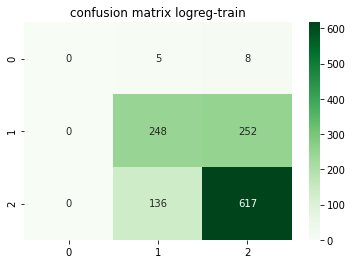

In [ ]:
predict_texts_logreg(logreg, train_text, train_label, "logreg-train")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.46      0.62      0.53       371
           2       0.82      0.69      0.75       895

    accuracy                           0.67      1266
   macro avg       0.43      0.44      0.43      1266
weighted avg       0.72      0.67      0.69      1266

predicted label:  {1, 2}
Accuracy: 0.6714060031595577
Precision: 0.6572754335316424
Recall: 0.6714060031595577
F1 Score: 0.656300343200801


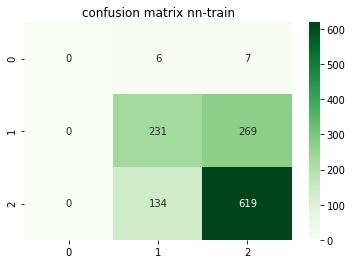

In [ ]:
predict_texts_nn(train_loader, "nn-train")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.54      0.70      0.61       455
           2       0.70      0.48      0.57       579

    accuracy                           0.58      1034
   macro avg       0.42      0.39      0.40      1034
weighted avg       0.63      0.58      0.59      1034

predicted label:  {1, 2}
Accuracy: 0.5783365570599613
Precision: 0.5818787320055097
Recall: 0.5783365570599613
F1 Score: 0.5665154523772464


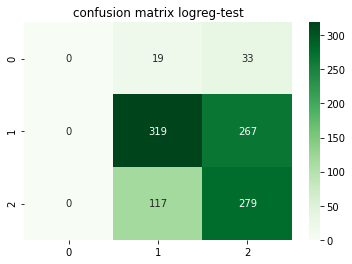

In [ ]:
predict_texts_logreg(logreg, test_text, test_label,"logreg-test")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.52      0.72      0.60       425
           2       0.75      0.49      0.59       609

    accuracy                           0.58      1034
   macro avg       0.42      0.40      0.40      1034
weighted avg       0.66      0.58      0.60      1034

predicted label:  {1, 2}
Accuracy: 0.5822050290135397
Precision: 0.593485811586023
Recall: 0.5822050290135397
F1 Score: 0.5683021793043062


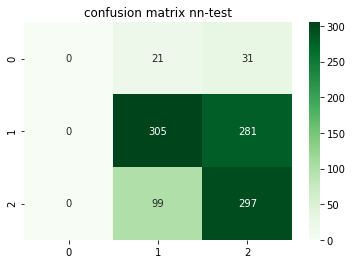

In [ ]:
predict_texts_nn(test_loader,"nn-test")

# unmount and flush google drive

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()